#Notebook for Analyzing Data from Individual Graphs

This notebook contains the code needed to analyze the data sets containing both Hutchinson et al.'s semantic priming data and the minimum path length between prime and target nodes in each graph.

###Imports

In [ ]:
import ast
import pandas as pd
import sys
import typing_extensions as typing
import numpy as np
from tqdm.auto import tqdm
from google.colab import drive
from scipy.stats import f, t, zscore
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

###Set the Model, Temperature, and Maximum Output Tokens that Generated the Graph You Want to Analyze

In [ ]:
model = "gemini-1.5-pro-001"
temperature = 0
max_output_tokens = 512

###Prepare the Semantic Priming and Minimum Path Length Data for Analysis

In [ ]:
words_df = pd.read_csv(f'/data/path_length_rt_data'
f'results_model_{model}_temp{temperature}_maxout{max_output_tokens}.csv')

# Find the maximum non-infinite value in the 'distance' column
max_distance = np.nanmax(words_df['distance'][np.isfinite(words_df['distance'])])

# Replace infinite values with max_distance + 1
words_df['distance'] = words_df['distance'].replace(np.inf, max_distance + 1)

words_df['z_distance'] = zscore(words_df['distance'])

words_df['Trial'] = zscore(words_df['Trial'])

###Run a Mixed-Effects Linear Regression, Treating the Participant as a Random Effect

In [ ]:
mod = smf.mixedlm('RT ~ z_distance + Trial + Session',
            data=words_df,
            groups=words_df["Subject"],
            re_formula="1 + z_distance + Trial + Session").fit()
print(mod.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    RT          
No. Observations:    423887     Method:                REML        
No. Groups:          512        Scale:                 0.6885      
Min. group size:     594        Log-Likelihood:        -525507.9371
Max. group size:     831        Converged:             Yes         
Mean group size:     827.9                                         
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                -0.024    0.027 -0.900 0.368 -0.077  0.029
z_distance                0.031    0.001 21.268 0.000  0.028  0.034
Trial                     0.071    0.006 12.020 0.000  0.060  0.083
Session                   0.018    0.015  1.187 0.235 -0.011  0.047
Group Var                 0.366    0.028                       

###Generate a Bar Chart Showing the Relationship between the Minimum Path Length Between Prime and Target Nodes and Reaction Time in Hutchinson et al.'s Data

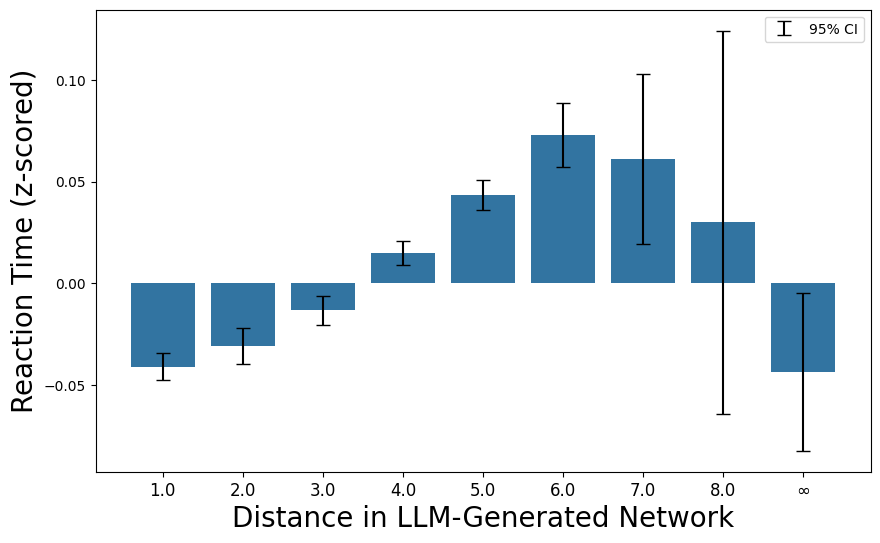

In [ ]:
# Calculate mean, count, and standard deviation for each distance
summary_stats = words_df.groupby('distance')['RT'].agg(['mean', 'std', 'count'])
summary_stats = summary_stats.reset_index()
summary_stats.rename(columns={'mean': 'RT', 'std': 'RT_SD'}, inplace=True)

# Calculate the 95% confidence intervals
confidence_level = 0.95
degrees_of_freedom = summary_stats['count'] - 1
ppf = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)
ci = ppf * (summary_stats['RT_SD'] / summary_stats['count']**0.5)
summary_stats['CI_lower'] = summary_stats['RT'] - ci
summary_stats['CI_upper'] = summary_stats['RT'] + ci

# Create the bar chart with 95% confidence intervals as error bars
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='distance',
    y='RT',
    data=summary_stats,
    capsize=0.2,
    errorbar=None
)

# Add custom error bars for 95% confidence intervals
plt.errorbar(
    x=range(summary_stats.shape[0]),
    y=summary_stats['RT'],
    yerr=ci,
    fmt='none',
    capsize=5,
    color='black',
    label='95% CI'  # Add label for error bars
)

# Modify x-axis labels to replace '9.0' with '∞'
xticks = list(summary_stats['distance'])
xticks = [str(x) if x != np.max(words_df['distance']) else '∞' for x in xticks]
plt.xticks(ticks=range(len(xticks)), labels=xticks, fontsize=12)

# Add labels and title
plt.xlabel('Distance in LLM-Generated Network', fontsize=20)
plt.ylabel('Reaction Time (z-scored)', fontsize=20)
plt.legend()
plt.show()
